In [1]:
import pandas as pd
import seaborn as sns
from utils.text import plot_wordclouds

In [2]:
binary=False
lowercase=True

# Carregando dados de análise

In [3]:
data_df = pd.read_csv("/home/kenzosaki/mestrado/data/tweetsentbr/tweetsentbr_test.csv", index_col=0)

In [4]:
id2label = {
    0: "neutro",
    1: "positivo",
    2: "negativo"
}

In [5]:
# Convertendo ids para labels para facilitar interpretação
data_df["label"] = data_df["label"].map(id2label)

In [6]:
data_df.head()

,label,text
2403,positivo,Começou o The Noite com o Charlie Hunnam
1349,negativo,"No twitter a 3ª feira é chata,pois todo mundo ..."
5422,neutro,Bial declamando os do garçom Conversa Com Bial
1262,neutro,AI MEU DEUS É AGORA Master Chef BR
5438,negativo,A Miriam só não roda pq eu acho que o tal sorv...


In [7]:
# Para focar a análise em apenas duas classes: positio e neutro
if binary:
    data_df = data_df[data_df["label"] != "neutro"]

if lowercase:
    data_df["text"] = data_df["text"].apply(lambda x: x.lower())

# Carregando Sentence-Bert

Sentence-Bert treinado a partir do Bertimbau e ajustado no ASSIN2.

In [8]:
from sentence_transformers import SentenceTransformer

In [9]:
model = SentenceTransformer("/home/kenzosaki/mestrado/data/models/similarity_bertimbau", device="cuda")

# Conversão dos textos para representações densas

Sentence-Bert converte textos para vetores densos de 768 dimensões.

In [10]:
text_vectors = model.encode(data_df["text"].values, show_progress_bar=True)

In [11]:
text_vectors.shape

(2463, 768)

# Agrupamento usando K-means

In [12]:
from sklearn.cluster import KMeans
from tqdm import tqdm

In [13]:
# Quantidades de clusters para avaliar
n_clusters = list(range(2,11))
n_clusters

[2, 3, 4, 5, 6, 7, 8, 9, 10]

In [14]:
fitted_models = []
for k in tqdm(n_clusters):
    
    kmeans = KMeans(n_clusters=k, n_init=100, init='random', max_iter=500)
    kmeans.fit(text_vectors)

    fitted_models.append(kmeans)

100%|██████████| 9/9 [00:30<00:00,  3.41s/it]


# Avaliando silhueta dos agrupamentos gerados

In [15]:
from sklearn.metrics import silhouette_samples, silhouette_score
from yellowbrick.cluster.silhouette import silhouette_visualizer
import numpy as np
import matplotlib.pyplot as plt

In [16]:
sns.set(rc={'figure.figsize':(15,6)})

In [17]:
silhouettes = [silhouette_score(text_vectors, kmeans.labels_) for kmeans in fitted_models]
inertias = [kmeans.inertia_ for kmeans in fitted_models]

Text(0.5, 0, 'Number of clusters')

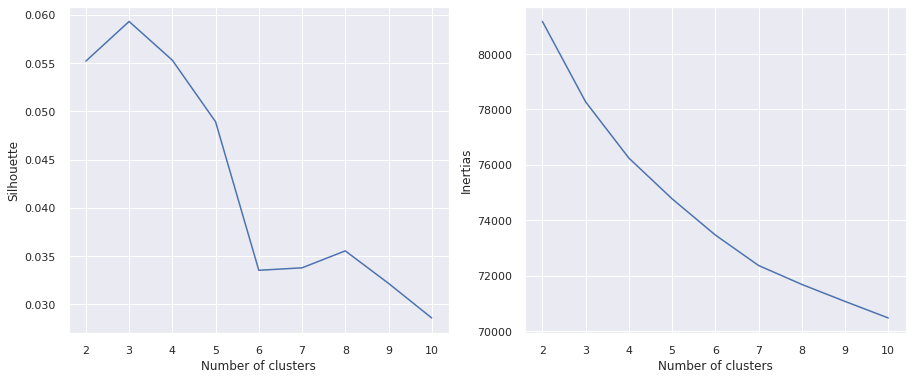

In [18]:
fig, axes = plt.subplots(1,2)

ax = sns.lineplot(x=n_clusters, y=silhouettes, ax=axes[0])
ax.set_ylabel("Silhouette")
ax.set_xlabel("Number of clusters")

ax = sns.lineplot(x=n_clusters, y=inertias, ax=axes[1])
ax.set_ylabel("Inertias")
ax.set_xlabel("Number of clusters")

In [19]:
# Escolhendo o modelo de maior silhueta mpedia para análise
kmeans = fitted_models[np.argmax(silhouettes)]
# kmeans = fitted_models[3]

In [20]:
data_df["silhouette"] = silhouette_samples(text_vectors, kmeans.labels_)
data_df["cluster"] = kmeans.labels_

In [21]:
mean_silh = data_df["silhouette"].mean()

In [22]:
print(f"- EE: {kmeans.inertia_}")
print(f"- Mean silhouette: {mean_silh}")

- EE: 78271.84375
- Mean silhouette: 0.059320639818906784


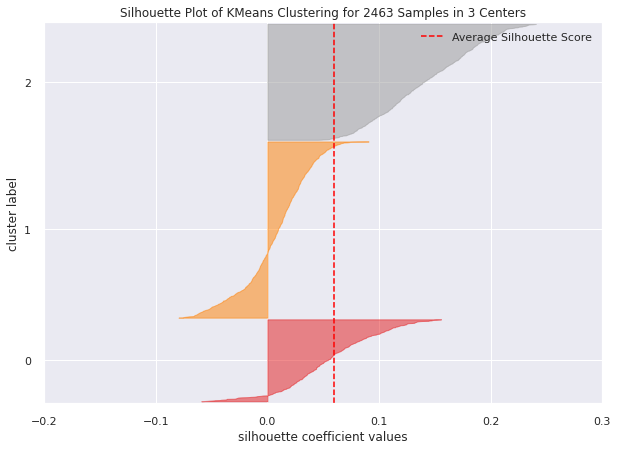

/home/kenzosaki/anaconda3/envs/transformers/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f70e5919690>,
                     model=None)

In [23]:
sns.set(rc={'figure.figsize':(10,7)})
silhouette_visualizer(
    kmeans,
    X=text_vectors,
    y=data_df["label"].values,
    is_fitted=True
)

# Comparação entre clusters

Comparando pares de clusters, com relação as classes (positivo, neutro ou negativo) e palavras frequentes.

In [32]:
cluster_pair = (0, 2)

In [33]:
c0_df = data_df[data_df["cluster"] == cluster_pair[0]]
c1_df = data_df[data_df["cluster"] == cluster_pair[1]]

## Distribuição de classes por cluster

In [34]:
order = ["positivo", "negativo"] if binary else \
        ["positivo", "neutro", "negativo"]

Text(0.5, 0, 'Cluster 2')

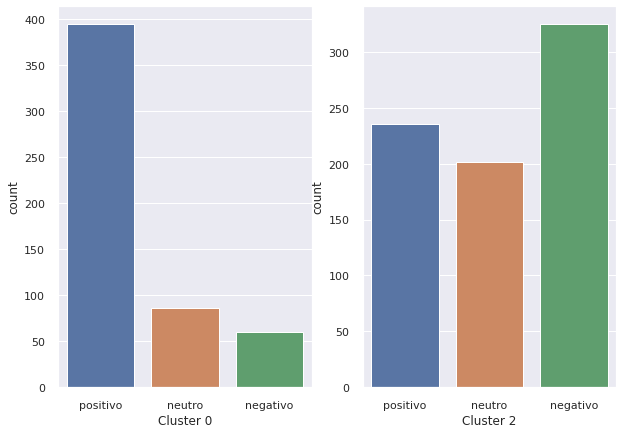

In [35]:
fig, axes = plt.subplots(1,2)

c0_df = data_df[data_df["cluster"] == cluster_pair[0]]
c1_df = data_df[data_df["cluster"] == cluster_pair[1]]

sns.countplot(data=c0_df, x="label", ax=axes[0], order=order)
axes[0].set_xlabel(f"Cluster {cluster_pair[0]}")
sns.countplot(data=c1_df, x="label", ax=axes[1], order=order)
axes[1].set_xlabel(f"Cluster {cluster_pair[1]}")

## Wordclouds por cluster

Gerando nuvens de palavras para cluster do par em análise.

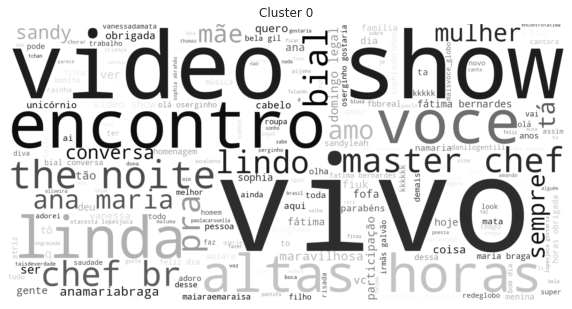

In [36]:
plot_wordclouds(
    text=" ".join(c0_df["text"].values.tolist()),
    title=f"Cluster {cluster_pair[0]}",
    colormap="binary", 
    background_color='white',
    max_words=200,
    width=1600, height=800
)

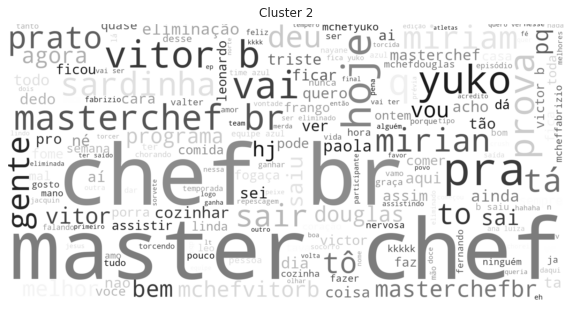

In [37]:
plot_wordclouds(
    text=" ".join(c1_df["text"].values.tolist()),
    title=f"Cluster {cluster_pair[1]}",
    colormap="binary", 
    background_color='white',
    max_words=200,
    width=1600, height=800
)

# Visualizando exemplos de maior silhueta por cluster

In [38]:
cluster = 2
c_df = data_df[data_df["cluster"] == cluster]

In [39]:
pd.set_option('max_colwidth', None)
c_df.sort_values(by="silhouette", ascending=False).head(10)

,label,text,silhouette,cluster
5012,positivo,vai q é tua mozão master chef br,0.240414,2
1262,neutro,ai meu deus é agora master chef br,0.239398,2
1734,neutro,só sai miriam master chef br,0.238206,2
6592,positivo,eu amo master chef br isso é sério,0.235454,2
8482,positivo,eu amo o fogaça master chef br,0.233943,2
3735,negativo,repetido carai master chef br,0.233825,2
6575,positivo,o vitor é meu orgulho master chef br,0.233328,2
1823,negativo,"não tira o vitor b não, please master chef br",0.232859,2
3741,positivo,agora bateu a fome master chef br,0.232638,2
292,negativo,ai gnt que nervoso master chef br,0.232374,2
